In [1]:
import becquerel as bq
from becquerel import Spectrum
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.insert(0,r"C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis")

In [2]:
import PF
import naa_isotope_analyzer as naa
import analysis_methods as am
import ROI
importlib.reload(PF)
importlib.reload(naa)
importlib.reload(am)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\Daniel\\Desktop\\Radwatch\\radwatch-analysis\\ROI.py'>

In [3]:
ecal_filename = r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\11-19-2019-Calibration.Ent"
bg_spec = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\Background_Spectrum_12_20_19.Spe")
e_cal = np.loadtxt(ecal_filename)
#detector ϵ placeholder = .001
#save daignostic plots as figures, save them for presentation and write up purposes

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\Background_Spectrum_12_20_19.Spe


In [4]:
def f_near(a,a0):
    idx = np.abs(a - a0).argmin()
    return idx

In [5]:
def get_isotopes(energies):
    hl_cut = 3600
    br_cut =4.0
    df = naa.naa_isotope_analyzer(energies.tolist(),hl_cut,br_cut)
    
    return df

In [6]:
def sample_energies(spec_30,spec_03,spec_24,bg_spec,ecal_filename):  #break this out into a couple of methods, check if fits need to be updated, use modified fit results to get counts, and those counts at fixed peaks are inputs for the next step
    #calibrate spectra
    spec1 = apply_ecal(spec_30,ecal_filename)
    spec2 = apply_ecal(spec_03, ecal_filename) #do energy cal outside and input calibrated spectra
    spec3 = apply_ecal(spec_24, ecal_filename)
    bg_spec = apply_ecal(bg_spec,ecal_filename)
    
    spec1_e = get_energies(spec1)
    spec2_e = get_energies(spec2)
    spec3_e = get_energies(spec3)
    
    s1_e = spec1_e.tolist()
    s2_e = spec2_e.tolist()
    s3_e = spec3_e.tolist()
    
    #find method to get rid of peaks in overflow bin
    
    s1_e = s1_e[0:-2]
    s2_e = s2_e[0:-2]
    s3_e = s3_e[0:-2]
    print("spec 1 energies", s1_e)
    print("spec 2 energies", s2_e)
    
    
    energies = [list(map(int,s1_e)),list(map(int,s2_e)),list(map(int,s3_e))] #return list of final energies
    #make counts lists a seperate function to determine which counts works or not
    counts=[]
    counts = counts.append([get_counts(spec_30,bg_spec)[0]]) #to get counts from list (also want uncertainties)
    counts = counts.append(counts, [get_counts(spec_03,bg_spec)])
    counts = counts.append(counts,[get_counts(spec_24,bg_spec)])
    
    #separate  function input energies and working counts
    m1 = {'energies':energies[1],'counts':counts[1]}
    m2 = {'energies':energies[2],'counts':counts[2]}
    m3 = {'energies':energies[3],'counts':counts[3]}
    
    df1 = pd.DataFrame(m1)
    df2 = pd.DataFrame(m2)
    df3 = pd.DataFrame(m3)
    
    ordered_set = pd.merge_ordered(df1,df2,df3)
    
    #order energies from low to high, parsing through list, length of energy array for each spec will be dif
    #associate the counts with an energy, if energy is a few kev off will they be considered different
    #data frame for each spectrum, then combine and let pandas sort, group energies within range and convert to integers
    #counts and uncertainties for sodium from 3 spectra (1 sample) and a function to c

In [7]:
def plot_peak_region(spectrum,source_energies): #ruiqi code!
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)

In [8]:
spec_01_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-30min.Spe")
spec_01_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-3hr.Spe")
spec_01_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-24hr.Spe")
spec_02_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-30min.Spe")
spec_02_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-3hr.Spe")
spec_02_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-24hr.Spe")
spec_03_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-30min.Spe")
spec_03_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-3hr.Spe")
spec_03_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-24hr.Spe")
spec_04_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1904-30min.Spe")
spec_04_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1904-3hr.Spe")
spec_04_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1904-24hr.Spe")
spec_05_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1905-30min.Spe")
spec_05_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1905-3hr.Spe")
spec_05_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1905-24hr.Spe")
spec_06_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1906-30min.Spe")
spec_06_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1906-3hr.Spe")
spec_06_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1906-24hr.Spe")
spec_07_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1907-30min.Spe")
spec_07_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1907-3hr.Spe")
spec_07_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1907-24hr.Spe")
spec_08_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1908-30min.Spe")
spec_08_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1908-3hr.Spe")
spec_08_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1908-24hr.Spe")
spec_09_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-30min.Spe")
spec_09_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-3hr.Spe")
spec_09_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-24hr.Spe")
spec_10_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1910-30min.Spe")
spec_10_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1910-3hr.Spe")
spec_10_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1910-24hr.Spe")

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-3hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-24hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-3hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1902-24hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-3hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1903-24hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1904-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1904-3hr.Spe
SpeFile: Reading file C:\Users\D

In [9]:
spectra_30 = [spec_01_30, spec_02_30, spec_03_30, spec_04_30,spec_05_30,spec_06_30,spec_07_30, spec_08_30,spec_09_30,spec_10_30]
spectra_03 = [spec_01_03,spec_02_03,spec_03_03,spec_04_03,spec_05_03,spec_06_03,spec_07_03,spec_08_03,spec_09_03,spec_10_03]
spectra_24 = [spec_01_24,spec_02_24,spec_03_24,spec_04_24,spec_05_24,spec_06_24,spec_06_24,spec_08_24,spec_09_24,spec_10_24]
cal_specs1 = []
cal_specs2 = []
cal_specs3 =[]
for i in range(len(spectra_30)):
    cal_specs1.append(am.apply_ecal(spectra_30[i],e_cal))
    cal_specs2.append(am.apply_ecal(spectra_03[i],e_cal))
    cal_specs3.append(am.apply_ecal(spectra_24[i],e_cal))

In [10]:
print(len(cal_specs1))

10


In [11]:
bg_spec = am.apply_ecal(bg_spec, e_cal)

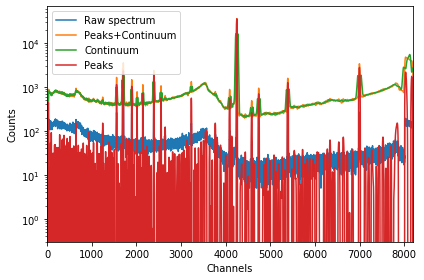

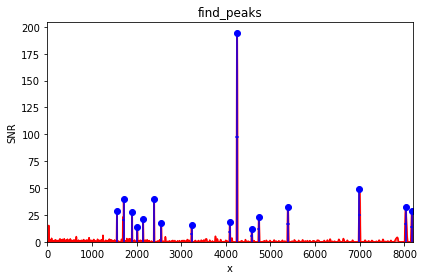

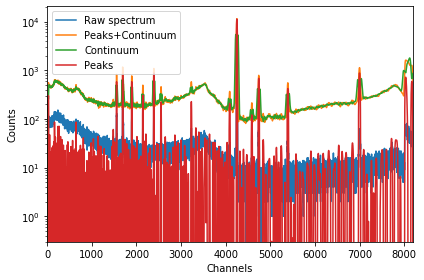

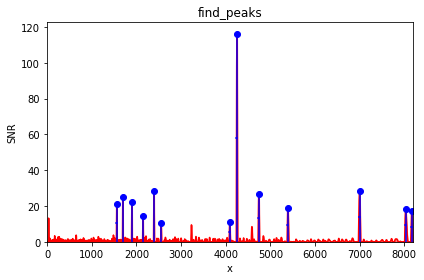

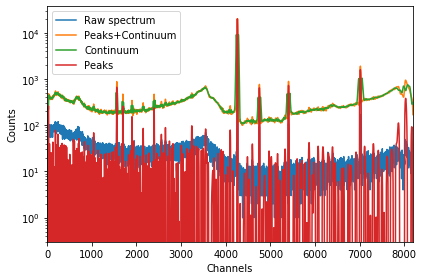

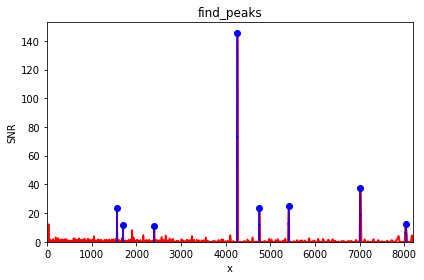

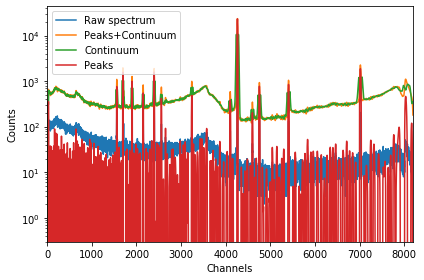

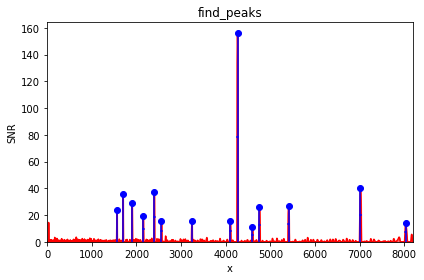

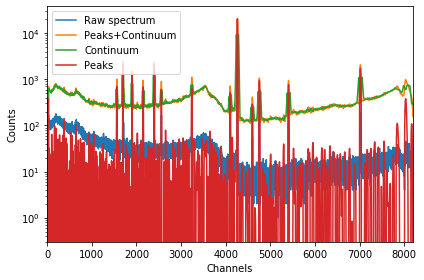

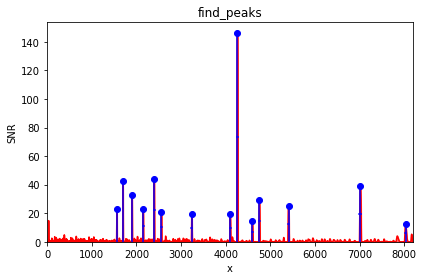

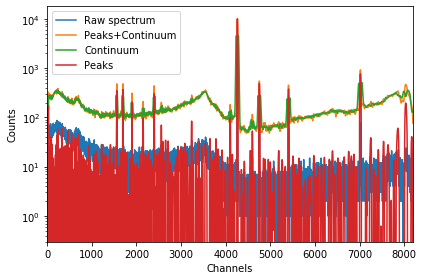

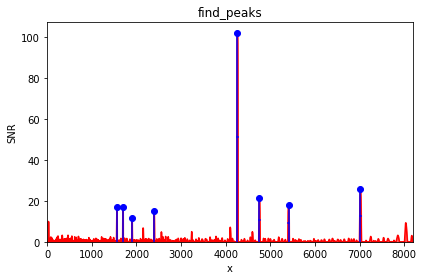

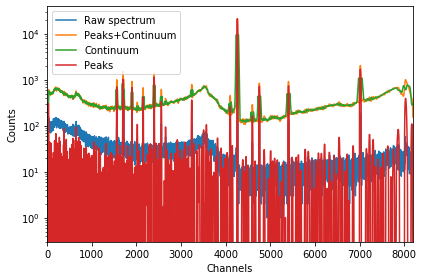

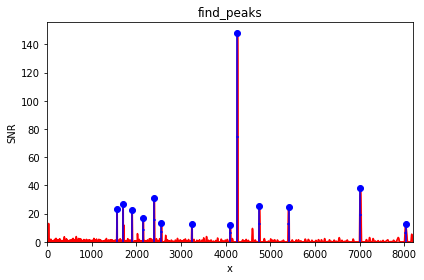

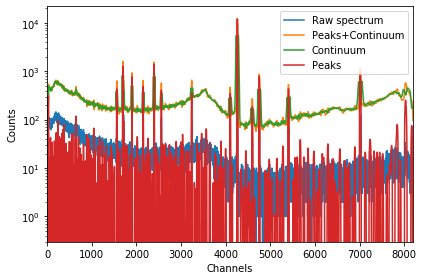

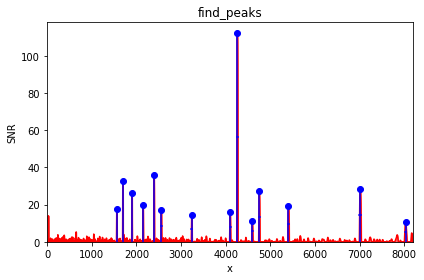

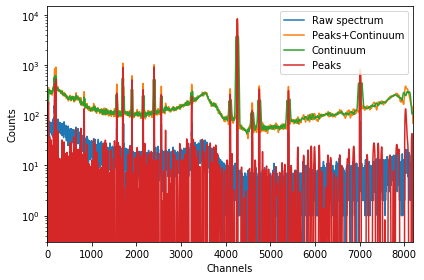

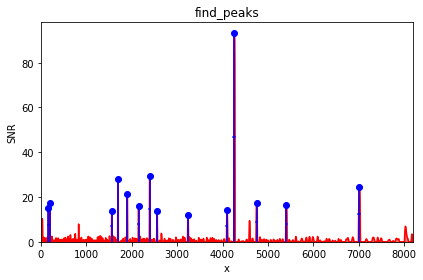

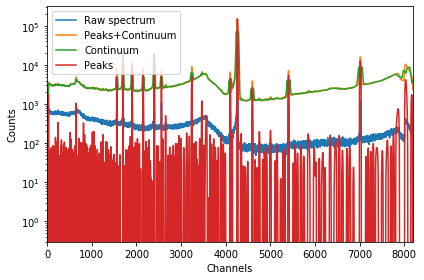

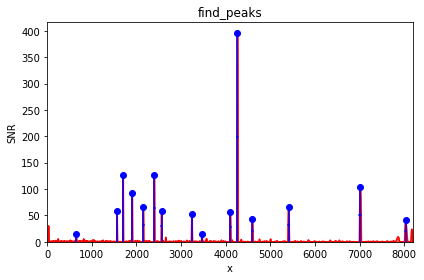

In [12]:
energies30 = []
energies03 = []
energies24 = []
for i in range(len(cal_specs1)):
    energies30.append(am.get_energies(cal_specs1[i]))
    #energies03.append(am.get_energies(cal_specs2[i]))
    #energies24.append(am.get_energies(cal_specs3[i]))
#the remove last two energies doesn't work for many plots

In [14]:
iso_dfs =[]
for e in energies30:
    iso_dfs.append(get_isotopes(e))
    
print(iso_dfs)

Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['TE131'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['BR82'], ['K42'], [], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['K42'], [], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['NA24'], ['K42'], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['BR82'], ['K42'], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['BR82'], ['K42'], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['ZN71'], ['BR82'], ['NA24'], ['K42']]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['K42'], []]
Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['BR82'], ['K42'], []]
Verified Isotopes, [['PT197'], ['PT197'], ['ZN71'], ['BR82'],

In [18]:
na_energies=[]
for i in range(len(cal_specs1)):
    na_energies.append(1364)
print((na_energies))
print(len(cal_specs1))

[1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364]
10


In [19]:
na_energies2=[]
for i in range(len(cal_specs2)):
    na_energies2.append(1364)

na_energies3=[]
for i in range(len(cal_specs3)):
    na_energies3.append(1364)

In [20]:
counts30 = []
uncertainties30 =[]
for i in range(len(cal_specs1)):
    icounts, iuncertainties = am.get_counts(cal_specs1[i],bg_spec,[na_energies[i]])
    counts30.append(icounts)
    uncertainties30.append(iuncertainties)

C:\Users\Daniel\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


In [ ]:
counts03 = []
uncertainties03 = []
counts24 =[]
uncertainties24 = []
for i in range(len(cal_specs2)):
    icounts, iuncertainties = am.get_counts(cal_specs2[i],bg_spec,[na_energies2[i]])
    counts03.append(icounts)
    uncertainties03.append(iuncertainties)

for i in range(len(cal_specs3)):
    icounts, iuncertainties = am.get_counts(cal_specs3[i],bg_spec,[na_energies3[i]])
    counts24.append(icounts)
    uncertainties24.append(iuncertainties)


In [21]:
print(counts30)#convert to cps
print(uncertainties30)

[array([39203.07436179]), array([16088.33160133]), array([21663.21308646]), array([25039.90507205]), array([21936.69353382]), array([10648.65893519]), array([22459.44636496]), array([12904.13623936]), array([8864.73613622]), array([169287.69023292])]
[array([346.19669573]), array([348.21778254]), array([21663.21308646]), array([205.18933448]), array([204.41266994]), array([10648.65893519]), array([195.82703079]), array([127.75987486]), array([98.59799803]), array([2454.65327232])]


In [ ]:
print(cal_specs[0].start_time)
print(cal_specs[1].start_time)
print(cal_specs[2].start_time)

In [22]:
cps=[]
uncs =[]
for i in range(len(cal_specs1)):
    cps.append(counts30[i]/cal_specs1[i].livetime)
    uncs.append(uncertainties30[i]/cal_specs1[i].livetime)
print(cps)
print(uncs)

[array([21.77948576]), array([8.937962]), array([12.03511838]), array([13.91105837]), array([12.18705196]), array([5.91592163]), array([12.4774702]), array([7.16896458]), array([4.92485341]), array([94.0487168])]
[array([0.1923315]), array([0.19345432]), array([12.03511838]), array([0.11399407]), array([0.11356259]), array([5.91592163]), array([0.10879279]), array([0.07097771]), array([0.05477667]), array([1.36369626])]


In [ ]:
cps2 =[]
uncs2 =[]
cps3 =[]
uncs3 = []

for i in range(len(cal_specs2)):
    cps2.append(counts03[i]/cal_specs2[i].livetime)
    uncs2.append(uncertainties03[i]/cal_specs2[i].livetime)
    
for i in range(len(cal_specs3)):
    cps3.append(counts24[i]/cal_specs3[i].livetime)
    uncs3.append(uncertainties24[i]/cal_specs3[i].livetime)
    
print(cps3)

In [25]:
ϵ = .005
br = 1
A1=[]
unc1 = []
for i in range(len(counts30)):
    A1.append(am.iso_activity(cps[i],br,ϵ))
    unc1.append(am.iso_activity(uncs[i],br,ϵ))
    
A1 = [int(i) for i in A1]
unc1=[int(i) for i in unc1]
print(A1)
print(unc1)

[4355, 1787, 2407, 2782, 2437, 1183, 2495, 1433, 984, 18809]
[38, 38, 2407, 22, 22, 1183, 21, 14, 10, 272]


In [26]:
A2=[]
unc2 = []
A3 = []
unc3 =[]
for i in range(len(counts03)):
    A2.append(am.iso_activity(cps2[i],br,ϵ))
    unc2.append(am.iso_activity(uncs2[i],br,ϵ))
    
A2 = [int(i) for i in A2]
unc2=[int(i) for i in unc2]

for i in range(len(counts24)):
    A3.append(am.iso_activity(cps3[i],br,ϵ))
    unc3.append(am.iso_activity(uncs3[i],br,ϵ))
    
A3 = [int(i) for i in A3]
unc3=[int(i) for i in unc3]

print(A2)
print(A3)

NameError: name 'counts03' is not defined

In [30]:
t0 = cal_specs1[0].start_time.timestamp() - (4*24*60*60)

In [31]:
dts=[]
dts2 = []
dts3 = []
for i in range(len(cal_specs1)):
    dts.append(am.get_dt(cal_specs1[i],t0))
print(dts)

for i in range(len(cal_specs2)):
    dts2.append(am.get_dt(cal_specs2[i],t0))
    
for i in range(len(cal_specs3)):
    dts3.append(am.get_dt(cal_specs3[i],t0))

[345600.0, 347680.0, 349797.0, 352922.0, 355619.0, 357962.0, 359898.0, 362325.0, 364283.0, 366355.0]


In [32]:
flux = 2*10**11 
Tirrad = 1 *3600 #sec
hl_na24 = 14.9 *3600 #sec
xs_na24 = 0.531399 * (1*10**-24)
M_A = 22.989769 #g/mol
sample_wt = 1 #g
iso_abundance =1 #100% na23

In [34]:
a0 =A1[0]* m.exp(m.log(2)/hl_na24 * dt0)
a1 = A1[1]* m.exp(m.log(2)/hl_na24 * dt1)
unc0 =unc[0]* m.exp(m.log(2)/hl_na24 * dt0)
unc1 = unc[1]* m.exp(m.log(2)/hl_na24 * dt1)
print(a0,"+/-",unc0)
print(a1,unc1)

NameError: name 'dt0' is not defined

In [ ]:
na_weight0 = element_weight(A[0], M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dt0)
na_weight1 = element_weight(A[1], M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dt1)
na_weight2 = element_weight(A[2], M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dt2)
print(na_weight0,na_weight1,na_weight2)

In [ ]:
na_ppm =[]
na_uncs =[]
for i in range(len(A)):
    na_ppm.append(am.element_weight(A[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts[i])*1000000)
    na_uncs.append(am.element_weight(unc[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts[i])*1000000)

In [ ]:
print(na_uncs)

In [ ]:
samples = ["Petrale Sole 1","Halibut","Tilapia","Rockfish","Rock Cod","Catfish","Petrale Sole 2", "Wild King Salmon","Swordfish","Oyster"]

In [ ]:
fig,ax=plt.subplots()
plt.errorbar(samples,na_ppm,yerr = na_uncs,linestyle = "None", marker = "o",markersize = 5, capsize = 5, markerfacecolor ="m")
plt.title("Sodium PPM in Fish Samples for 30min Measurements")
plt.grid(True)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("Samples")
plt.ylabel("Amount Na(PPM)")

In [ ]:
na_ppm2 =[]
na_uncs2 =[]
na_ppm3 = []
na_uncs3 =[]
for i in range(len(A2)):
    na_ppm2.append(am.element_weight(A2[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts2[i])*1000000)
    na_uncs2.append(am.element_weight(unc2[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts2[i])*1000000)
    
for i in range(len(A3)):
    na_ppm3.append(am.element_weight(A3[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts3[i])*1000000)
    na_uncs3.append(am.element_weight(unc3[i],M_A,iso_abundance,hl_na24,flux,xs_na24,Tirrad,dts3[i])*1000000)

In [ ]:
fig,ax=plt.subplots()
plt.errorbar(samples,na_ppm2,yerr = na_uncs2,linestyle = "None", marker = "o",markersize = 5, capsize = 5,markerfacecolor ="r")
plt.title("Sodium PPM in Fish Samples for 3 Hr Measurements")
plt.grid(True)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("Samples")
plt.ylabel("Amount Na(PPM)")

In [ ]:
fig,ax=plt.subplots()
plt.errorbar(samples,na_ppm3,yerr = na_uncs3,linestyle = "None", marker = "o",markersize = 5, capsize = 5, markerfacecolor ="c")
plt.title("Sodium PPM in Fish Samples for 24 Hr Measurements")
plt.grid(True)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("Samples")
plt.ylabel("Amount Na(PPM)")

In [ ]:
fig, ax = plt.subplots()
X = np.arange(len(samples))
ax.bar(X + 0.00, na_ppm, yerr = na_uncs, color = 'r', width = 0.35, capsize =2, label ="Na (ppm) 30 min")
ax.bar(X + 0.30, na_ppm2, yerr = na_uncs2, color = 'm', width = 0.35, capsize = 2, label = "Na (ppm) 3 Hr")
ax.bar(X + 0.60, na_ppm3,yerr =na_uncs3, color = 'c', width = 0.35, capsize =2, label = "Na (ppm) 24 Hr")
plt.grid(True)
ax.set_xticks(X)
ax.set_xticklabels(samples)
ax.tick_params(axis='x', rotation=45)
plt.ylabel("Na Concentration (ppm)")
plt.xlabel("Samples")
plt.title("Na Concentration (ppm) across all samples")
plt.legend()
fig.set_size_inches(15, 8)

In [162]:
plot_peak_region(cal_specs[0],energies[0])

TypeError: 'numpy.float64' object is not iterable

In [127]:
#sample_energies(spec_01_30,spec_01_03,spec_01_24, bg_spec,ecal_filename)
#be able to catch the energy that isn't working and remove it until it works
#run isotope analyzer on these lists of energies
#focus on sodium isotope counts from its peak on many spectra, concentration caluculation for each spectra serparately (diff time of irradiation and measuring)

In [193]:
matrix = [nrgs_01_30,pc_01_03]
matrix

[array([ 508.36293069,  556.60889225,  616.28152893,  653.73563067,
         695.31603176,  773.08090402,  824.18353436, 1039.7033232 ,
        1311.72167229, 1362.82430263, 1468.52104738, 1518.67145479,
        1724.98642202, 2234.10827959]),
 array([ 2079.60564416,  3344.05889826,  1281.76350298,   435.55370209,
          823.22236905,  2244.95509005,   649.31358995,   640.3868777 ,
          580.99214977, 39199.70657593,   291.56917885,   765.29528004,
         1382.09446878,  3094.69676829])]